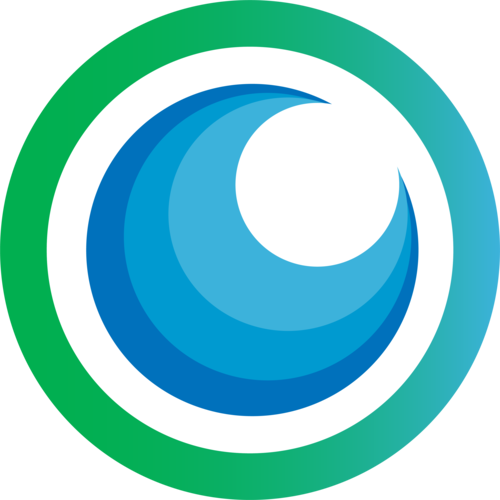
# Epoch Tutorials: Preprocessing

### Introduction
This notebook is part of the Epoch III onboarding for the engineers departement, and can be used as reference for future competitions on the topic of preprocessing. 

### Data
The dataset that is used for this tutorial contains bike rental information per hour in a large European city.
It contains 15 features collected. The goal is to predict the total numbers of bikes rented, which is the 'Total' column.
The dataset consists of 17378 different points. There is no predefined train/test split.

### Contents
- [Common Pandas Dataframe operations](#Common-Pandas-Dataframe-operations)
- [Visualizing our data](#Visualizing-our-data)
- [Dimensionality Reduction](#Dimensionality-Reduction)
- [Outlier Detection](#Outlier-Detection)
- [Train, Validate, and Test](#Train,-Validate,-and-Test)
   


In [351]:
# Imports for this tutorial
# Run "pip install -r requirements.txt" in the root folder of the repository to ensure all packages are installed
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import sklearn

import warnings
warnings.filterwarnings('ignore')

### Common Pandas Dataframe operations

In [352]:
# Load data in dataframe
def load_dataframe(path: str) -> pd.DataFrame:
    """
    Method to load data from file into pd.DataFrame
    """
    return pd.read_csv(path)


# Write DataFrame to csv (usually for submissions)
def write_dataframe(data: pd.DataFrame, path: str):
    """
    Method to load data from file into pd.DataFrame
    """
    index = False  # If true, add a column of consecutive integers to the left of the csv
    return data.to_csv(path, index=index)

In [353]:
# Load and print data
df = load_dataframe("../data/bike_rental_data.csv")
df.head()

,Unnamed: 0,instant,date,season,year,month,hour,weekday,weather,temperature,feeling_temperature,humidity,windspeed,Subscribed,Non-subscribed,Total
0,0,1,2011-01-01,winter,0,Jan,0,Sat,Clear or partly cloudy,3.28,3.0014,81.0,0.0,3,13,16
1,1,2,2011-01-01,winter,0,Jan,1,Sat,Clear or partly cloudy,2.34,1.9982,80.0,0.0,8,32,40
2,2,3,2011-01-01,winter,0,Jan,2,Sat,Clear or partly cloudy,2.34,1.9982,80.0,0.0,5,27,32
3,3,4,2011-01-01,winter,0,Jan,3,Sat,Clear or partly cloudy,3.28,3.0014,75.0,0.0,3,10,13
4,4,5,2011-01-01,winter,0,Jan,4,Sat,Clear or partly cloudy,3.28,3.0014,75.0,0.0,0,1,1


In [354]:
# Drop columns we are not going to use
#     - Index columns (Unnamed: 0 and instant)
#     - Date column (since year, month, and hour are present)
#     - Subscribed and Non-subscribed (since sum equals Total column)
# IMPORTANT: You can do many pandas operations inplace or not, pay attention to this

# Drop columns (axis=1 are columns) inplace
columns_to_drop = ['Unnamed: 0', 'instant', 'date', 'Subscribed', 'Non-subscribed']
df.drop(columns_to_drop, axis=1, inplace=True)

In [355]:
# Preprocessing the dataset : useful functions

# If missing or nan values exist in the data, you want to replace them (with 0, or mean, or something else)
# With pandas
df.fillna(0, inplace=True)

# With numpy
df.replace(np.nan, 0, inplace=True)

# Very likely, 'object' columns should be processed, since they are often categorical
print(df.dtypes)

season                  object
year                     int64
month                   object
hour                     int64
weekday                 object
weather                 object
temperature            float64
feeling_temperature    float64
humidity               float64
windspeed              float64
Total                    int64
dtype: object


In [356]:
# Preprocessing columns in one loop to floats
for column_name, column_dtype in zip(df.columns, df.dtypes):
    
    # Categorical to int
    if column_dtype == "object":
        df[column_name] = pd.factorize(df[column_name])[0]
        
    # All columns to float
    df[column_name] = list(map(float, df[column_name]))

print(df.dtypes)

season                 float64
year                   float64
month                  float64
hour                   float64
weekday                float64
weather                float64
temperature            float64
feeling_temperature    float64
humidity               float64
windspeed              float64
Total                  float64
dtype: object


In [357]:
# Normalize our data, so large ranges do not have more impact on our data
# Probably do not normalize your labels, most competitions require non-normalized submissions
labels = df['Total']

# Normalize (there are many ways, this is very short, NOT INPLACE!)
df_normalized = df.apply(lambda l: l / max(l), axis=0)
df_normalized.head()

,season,year,month,hour,weekday,weather,temperature,feeling_temperature,humidity,windspeed,Total
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.084103,0.060028,0.81,0.0,0.016377
1,0.0,0.0,0.0,0.043478,0.0,0.0,0.060000,0.039964,0.80,0.0,0.040942
2,0.0,0.0,0.0,0.086957,0.0,0.0,0.060000,0.039964,0.80,0.0,0.032753
3,0.0,0.0,0.0,0.130435,0.0,0.0,0.084103,0.060028,0.75,0.0,0.013306
4,0.0,0.0,0.0,0.173913,0.0,0.0,0.084103,0.060028,0.75,0.0,0.001024


### Visualizing our data

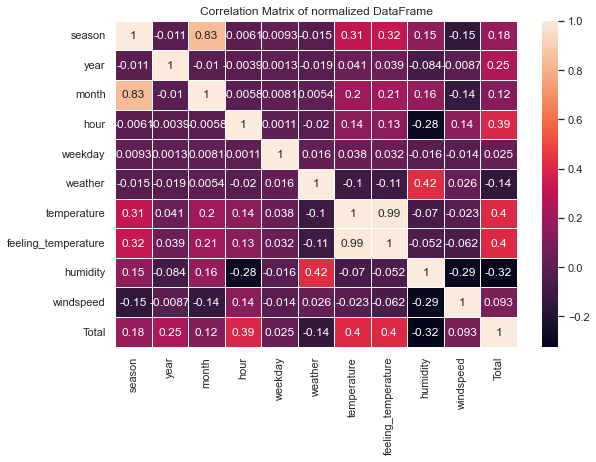

In [358]:
# Many visualizations are usefull in the process. Here, some basic ones are used
sn.set_theme()

# Draw a correlation matrix (how much variables correlate with each other)
f, ax = plt.subplots(figsize=(9, 6))
sn.heatmap(df_normalized.corr(), annot=True, linewidths=.5, ax=ax)
plt.title("Correlation Matrix of normalized DataFrame")
plt.show()

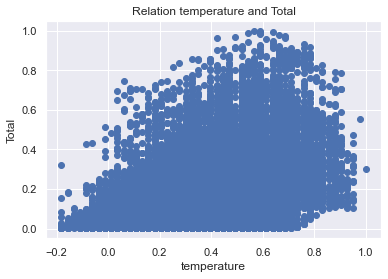

In [359]:
# Visualize two single variables
x_variable = "temperature"
y_variable = 'Total'

plt.scatter(df_normalized[x_variable], df_normalized[y_variable])
plt.xlabel(x_variable)
plt.ylabel(y_variable)
plt.title(f"Relation {x_variable} and {y_variable}")
plt.show()

### Dimensionality Reduction

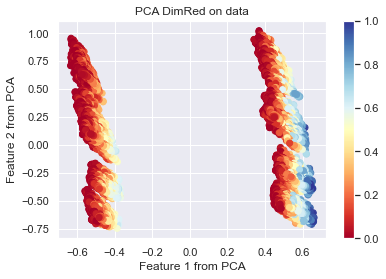

In [360]:
# Dimensionality reduction is often used for two purposes
#  - Visualizing multidimensional data in 2 dimensions
#  - Reducing complexity of high-dimensional data

# Dimensionality Reduction with PCA (preserves global structure)
from sklearn.decomposition import PCA

# Create and perform PCA
pca = PCA(n_components=2)
X_reduced_pca = pca.fit_transform(df_normalized.to_numpy())

# Plot 2-dimensional points with color scale according to normalized label
color_map = plt.cm.get_cmap('RdYlBu')
scatter_plot = plt.scatter(X_reduced_pca[:, 0], 
                 X_reduced_pca[:, 1], 
                 c=df_normalized['Total'], 
                 vmin=0, vmax=1, cmap=color_map)

plt.colorbar(scatter_plot)
plt.xlabel("Feature 1 from PCA")
plt.ylabel("Feature 2 from PCA")
plt.title("PCA DimRed on data")
plt.show()

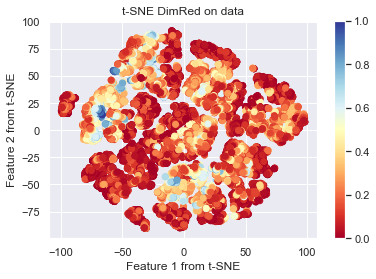

In [361]:
# Dimensionality Reduction with TSNE (preserves local structure)
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_reduced_tsne = tsne.fit_transform(df_normalized.to_numpy())

# Plot 2-dimensional points with color scale according to normalized label
color_map = plt.cm.get_cmap('RdYlBu')
scatter_plot = plt.scatter(X_reduced_tsne[:, 0], 
                 X_reduced_tsne[:, 1], 
                 c=df_normalized['Total'], 
                 vmin=0, vmax=1, cmap=color_map)

plt.colorbar(scatter_plot)
plt.xlabel("Feature 1 from t-SNE")
plt.ylabel("Feature 2 from t-SNE")
plt.title("t-SNE DimRed on data")
plt.show()

### Outlier Detection

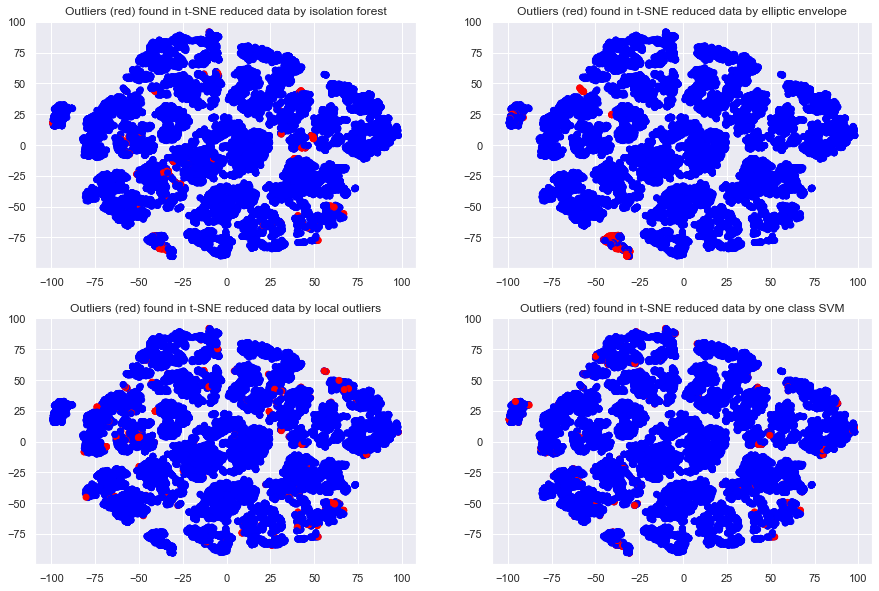

In [362]:
# There are several methods for outlier detection that can boost model performance
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

c = 0.01

def get_outlier_colors(outliers):
    return [[None, 'blue', 'red'][x] for x in outliers]

# Outlier Detection with Isolation Forest
isolation_forest_ouliers = get_outlier_colors(IsolationForest(contamination=c).fit_predict(df_normalized.to_numpy()))

# Outlier Detection with Elliptic Envelope
elliptic_envelope_outliers = get_outlier_colors(EllipticEnvelope(contamination=c).fit_predict(df_normalized.to_numpy()))

# Outlier Detection with Local Outlier Factor
local_outliers = get_outlier_colors(LocalOutlierFactor(contamination=c).fit_predict(df_normalized.to_numpy()))

# Outlier Detection with One-Class SVM
one_class_svm_ouliers = get_outlier_colors(OneClassSVM(nu=c).fit_predict(df_normalized.to_numpy()))


fig, axs = plt.subplots(2, 2, figsize=(15, 10))

axs[0, 0].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], color=isolation_forest_ouliers)
axs[0, 0].set_title('Outliers (red) found in t-SNE reduced data by isolation forest')

axs[0, 1].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], color=elliptic_envelope_outliers)
axs[0, 1].set_title('Outliers (red) found in t-SNE reduced data by elliptic envelope')

axs[1, 0].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], color=local_outliers)
axs[1, 0].set_title('Outliers (red) found in t-SNE reduced data by local outliers')

axs[1, 1].scatter(X_reduced_tsne[:, 0], X_reduced_tsne[:, 1], color=one_class_svm_ouliers)
axs[1, 1].set_title('Outliers (red) found in t-SNE reduced data by one class SVM')

plt.show()
    

### Train, Validate, and Test

In [374]:
# This section will use Random Forest to make predictions, another tutuorial will go in depth on different models
# Note we still have 'labels', the original labels for the data

# Drop labels from normalized dataframe

df_normalized = df_normalized.drop(['Total'], axis=1, inplace=False)
labels = labels.to_numpy()

print(f"Label Array: {labels}, with shape {labels.shape}")
df_normalized.head()

Label Array: [16. 40. 32. ... 90. 61. 49.], with shape (17379,)


,season,year,month,hour,weekday,weather,temperature,feeling_temperature,humidity,windspeed
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.084103,0.060028,0.81,0.0
1,0.0,0.0,0.0,0.043478,0.0,0.0,0.060000,0.039964,0.80,0.0
2,0.0,0.0,0.0,0.086957,0.0,0.0,0.060000,0.039964,0.80,0.0
3,0.0,0.0,0.0,0.130435,0.0,0.0,0.084103,0.060028,0.75,0.0
4,0.0,0.0,0.0,0.173913,0.0,0.0,0.084103,0.060028,0.75,0.0


In [384]:
# There is no clear train/test split!!!
# This means Cross-Validation is the most reliable way to test models
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor


def mean_absolute_error(estimator, X, y_true):
    y_pred = estimator.predict(X)
    return np.sum(np.abs(y_pred - y_true)) / len(y_pred)


# Perform cross validaton with 5 folds
model = RandomForestRegressor(n_estimators=50)
cv_score = np.mean(cross_val_score(model, 
                                   df_normalized.to_numpy(), 
                                   labels, 
                                   cv=5, 
                                   scoring=mean_absolute_error))

print(f"Mean Absolute Error of model: {cv_score}")

Mean Absolute Error of model: 45.24653861921833
